# Main
This is the main notebook of our project. It contains the data wranling part, the data analysis part and the graph generations. All graphs presents on the Data Story website are reproducible from there.  
The different sections of this notebook contain, for data wranling and data exploration:
* Import the movies from the CMU movies dataset. Clean the features.
* Filter movies to keep only those produced in the U.S.
* Import the movies from the Kaggle dataset. Ensure that it can be truster, and fill missing information of the movie CMU dataset using data from the Kaggle dataset.
* Add inflation data. Then, adapt the box office revenue and the budget with inflation, in order to be able to compare the movies based on the box office revenue.
* Data exploration: analyze the missing values in the important features. Remove the movies without NaN values
* Data exploration: analyze the movies box office revenue, the movies budget and the distribution of the number of movies over the decades.
* Load the character dataset
* Load the ethnicities
* Merge the movies and the characters together. After this step, we have access to every character that has participated to a movie
* Compute statistics on the characters of each movies, based on the gender, age, height and ethnicity  
  
Then, we seek to answer the following research questions:
* Which characteristics of movies are causing high movie box office revenue?
* Did ethnical diversity in successful movies change over time?ing high movie box office revenue?
* Did the gender ratio of the cast in successful movies change over time?
* Did the age distribution of men and women of the cast in successful movies change over time?  

In [88]:
DATA_FOLDER = './data/'
MOVIES_FOLDER = DATA_FOLDER + 'movies_summaries/'
PLOT_SUMMARY_FOLDER = DATA_FOLDER + 'corenlp_plot_summaries'
KAGGLE_FOLDER = DATA_FOLDER + 'kaggle/'

REPORT_FOLDER = './gen/reports/'
ETHNICITY_FILE = './gen/ethnicities.tsv'
PLOT_FOLDER = './gen/plots/'
INFLATION_FILE = DATA_FOLDER + 'inflation_data.csv'

CHARACTERS_FILE = MOVIES_FOLDER + 'character.metadata.tsv'
MOVIES_FILE = MOVIES_FOLDER + 'movie.metadata.tsv'
PLOT_SUMMARIES_FILE = MOVIES_FOLDER + 'plot_summaries.txt'
TROPES_FILE = MOVIES_FOLDER + 'tvtropes.clusters.txt'

KAGGLE_FILE = KAGGLE_FOLDER + 'movies_metadata.csv'

# country stutied in this notebook
TARGET_COUNTRIES = ['United States of America']

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from scipy import stats
from difflib import SequenceMatcher
from statsmodels.stats import diagnostic
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import ttest_ind, ttest_ind_from_stats

# from pandas_profiling import ProfileReport
%matplotlib inline

from data_wrangling_tools import *

# Load CMU movies dataset
We start by loading the movies from the CMU movies dataset.  
We apply some processing steps are done in order to clean the features:
* The unknown values in `countries`, `genres` and `languages` are set the "Unknown"
* The json features `countries`, `genres` and `languages` are converted to python lists
  
When, we filter the dataset in order to consider only the movies created in the U.S.

In [90]:
# load movies from CMU dataset

def load_cmu_movies(movies_file):
    """
        Load movies from the CMU movies dataset
    """
    movies_columns = ['wiki_movie_id', 'freebase_movie_id', 'name', 'release_date', 'box_office_revenue', 'runtime', 'languages', 'countries', 'genres']
    movies = pd.read_csv(movies_file, sep='\t', names=movies_columns) 

    # clean dates
    movies['release_date'] = pd.to_datetime(movies['release_date'], format='%Y-%m-%d', errors='coerce')

    return movies


movies_cmu = load_cmu_movies(MOVIES_FILE)

In [91]:
# Clean countries, genres and languages features

def clean_unknowns(input_df, features=['countries', 'genres', 'languages']):
    """
        Replace unkown values in countries, genres and languages
    """

    def replace_unknown(df, label):
        """
            Replace emtpy json with "Unknown"
        """
        return df[label].replace("{}", "{\"\": \"Unknown\"}")
    
    df = input_df.copy()

    for feature in features:
        df[feature] = replace_unknown(df, feature)

    return df


def clean_jsons(df_input, features=['countries', 'genres', 'languages']):
    """
        Replace json dictionnaries for countries, genres and languages
    """

    def extract_feature(json_):
        """
            Replace json dictionnaries with list of their values
        """
        if json_ is np.nan:
            return np.nan
        return list(ast.literal_eval(json_).values())

    df = df_input.copy()
    
    for feature in features:
        df[feature] = df[feature].apply(extract_feature)

    return df


movies_cmu = clean_unknowns(movies_cmu)
movies_cmu = clean_jsons(movies_cmu)

### Select only U.S. movies
Our analysis is based only on U.S. movies. Thus, we filter the movies in order to keep all movies which have been produced in at least the U.S. (i.e. in the U.S. and potentially other countries).

In [92]:
def filter_with_countries(df, target_countries, mode):
    """
        Filter countries produced in the target_countries list.
        The mode parameter can be: 
            'all' if all target countries need to be present
            'any' if one of the target countries need to be present
            'only' if only the target countries need to be present
    """
    if mode == 'all':
        return df[df["countries"].apply(lambda x: all(country in x for country in target_countries))]
    elif mode == 'any':
        return df[df["countries"].apply(lambda x: any(country in x for country in target_countries))]
    elif mode == 'only':
        return df[df["countries"].apply(lambda x: set(x) == set(target_countries))]
    else:
        raise ValueError('mode must be one of [all, any, only]')


nb_prev = movies_cmu.shape[0]
print('Number of movies in the whole dataset: {}'.format(movies_cmu.shape[0]))

# select only movies from the US
movies_cmu = filter_with_countries(movies_cmu, TARGET_COUNTRIES, 'any')
print('Number of movies produced in the U.S.: {} ({:.2%} of the whole dataset)'.format(movies_cmu.shape[0], movies_cmu.shape[0] / nb_prev))

print('The Movies CMU dataset contains U.S. movies up to 2012')
movies_cmu.head()

Number of movies in the whole dataset: 81741
Number of movies produced in the U.S.: 34408 (42.09% of the whole dataset)
The Movies CMU dataset contains U.S. movies up to 2012


,wiki_movie_id,freebase_movie_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi..."
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]"
10,175026,/m/017n1p,Sarah and Son,1930-01-01,NaN,86.0,[English Language],[United States of America],"[Drama, Black-and-white]"


### Load Kaggle movies dataset
The Kaggle movies are not used to add movies that are missing in the CMU movies dataset. They are used to add missing information about the movies present in the CMU movies dataset, such as IMDB ratings, missing box office revenue and budget.

In [93]:
# load kaggle dataset

def load_kaggle_movies(kaggle_file, columns=['original_title', 'revenue', 'budget', 'vote_average', 'vote_count', 'release_date']):
    """
        Load the Kaggle dataset
    """
    kaggle = pd.read_csv(kaggle_file, usecols=columns)

    # remove wrongly formatted rows (only 3)
    kaggle = kaggle.drop(kaggle[kaggle['budget'].str.contains('.jpg')].index)

    # convert date string to datetime objects
    kaggle['release_date'] = pd.to_datetime(kaggle['release_date'], format='%Y-%m-%d', errors='coerce')

    # convert numerical columns to float
    kaggle['revenue'] = kaggle['revenue'].astype(float).apply(lambda x: np.nan if x == 0.0 else x)
    kaggle['budget'] = kaggle['budget'].astype(float).apply(lambda x: np.nan if x == 0.0 else x)

    return kaggle


movies_kaggle = load_kaggle_movies(KAGGLE_FILE)
print(movies_kaggle.shape)
movies_kaggle.head()

(45463, 6)


,budget,original_title,release_date,revenue,vote_average,vote_count
0,30000000.0,Toy Story,1995-10-30,373554033.0,7.7,5415.0
1,65000000.0,Jumanji,1995-12-15,262797249.0,6.9,2413.0
2,NaN,Grumpier Old Men,1995-12-22,NaN,6.5,92.0
3,16000000.0,Waiting to Exhale,1995-12-22,81452156.0,6.1,34.0
4,NaN,Father of the Bride Part II,1995-02-10,76578911.0,5.7,173.0


### Check whether the Kaggle dataset can be trusted
Before adding information from the Kaggle dataset, we need to check whether the Kaggle dataset can be trusted. 
We will do so by checking whether the box office revenue in the CMU dataset and in the Kaggle dataset are the same.  
As you can see in the cell below, the box office revenue information is the same for every movie. Thus, we will add the information from the Kaggle dataset into to movies.

In [94]:
# check if Kaggle dataset can be trusted

df_trust = pd.merge(movies_cmu, movies_kaggle, left_on=[movies_cmu['name'], movies_cmu['release_date'].dt.year], 
                    right_on=[movies_kaggle['original_title'], movies_kaggle['release_date'].dt.year], how='left')
df_trust = df_trust.rename({'release_date_x': 'release_date', 'revenue':'box_office_revenue_kaggle'}, axis=1)
df_trust = df_trust.drop(columns=['original_title', 'key_0', 'key_1', 'release_date_y'])

# select only the rows where the box office revenue is known
df_trust = df_trust[(df_trust['box_office_revenue'].notna()) & (df_trust['box_office_revenue_kaggle'].notna())]

df_trust['box_office_revenue'] = df_trust['box_office_revenue'].astype(float)
df_trust['box_office_revenue_kaggle'] = df_trust['box_office_revenue'].astype(float)

# compare all values
is_same = np.allclose(df_trust['box_office_revenue'].to_numpy(), df_trust['box_office_revenue_kaggle'].to_numpy())

print("Are the values from Kaggle and the values from the movies dataset are the same? {}".format(is_same))

Are the values from Kaggle and the values from the movies dataset are the same? True


Now that we know that we can trust the Kaggle dataset, we will add the missing information in the CMU dataset.

In [95]:
# add information from the Kaggle dataset to the CMU movies dataset

def merge_cmu_kaggle_movies(movies, kaggle):
    """
        Merge the CMU movies dataset and the Kaggle movies dataset
        based on the movies name.
        Add missing box office information to the CMU movies dataset if they are
        available in the Kaggle dataset.
    """
    df = pd.merge(movies, kaggle, left_on=[movies['name'], movies['release_date'].dt.year], 
        right_on=[kaggle['original_title'], kaggle['release_date'].dt.year], how='left')
    df = df.rename({'release_date_x': 'release_date'}, axis=1)

    # fill the box_office revenue with the kaggle revenue if it's missing
    df['box_office_revenue'] = df['box_office_revenue'].fillna(df['revenue'].copy())
    df = df.drop(columns=['revenue', 'original_title', 'key_0', 'key_1', 'release_date_y'])
    
    return df


movies = merge_cmu_kaggle_movies(movies_cmu, movies_kaggle)

print(movies.shape)
movies.head()

(34431, 12)


,wiki_movie_id,freebase_movie_id,name,release_date,box_office_revenue,runtime,languages,countries,genres,budget,vote_average,vote_count
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",28000000.0,4.8,299.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",NaN,NaN,NaN
2,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi...",NaN,NaN,NaN
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",2000000.0,4.8,6.0
4,175026,/m/017n1p,Sarah and Son,1930-01-01,NaN,86.0,[English Language],[United States of America],"[Drama, Black-and-white]",NaN,NaN,NaN


### Add inflation data
TODO update to add budget too  
In order to be able to compare the movies from different years, we will correct the box office revenue and the budget for inflation. This means that all revenues will be expressed by the amount they would be if the movie have been released in 2022.  
  
In order to do so, we'll need to import the "inflation_data.csv" file which contains the following inflation data for the U.S., for each year:
* Amount: buying power of 1$ from 1914 in year `n`. In other word, how much 1$ from 1914 is valued in year `n`.
* Inflation rate: inflation rate at each given year

After importing it, use the following formula to compute the value of 1$ from 2016 in every other year:

$bo_{inflation} = \frac{bo_{base}(year_n) * i(year_{2022})}{i(year_n)}$  

In the cell below, we already the factor to get the value of the box office in year `n` to the 2022 budget. Then, we plot graphs which shows the buying power of 1$ of 1914 increasing over the years.

In [96]:
# Load inflation data

def load_inflation(inflation_file):
    """
        Load inflation data
    """

    inflation = pd.read_csv(inflation_file, index_col='year')
    inflation = inflation.rename(columns={'amount': 'amount_1900'})	

    reference_year = 2022
    inflation_reference_year = inflation.loc[reference_year, 'amount_1900']

    inflation['amount_2022'] = inflation['amount_1900'].apply(lambda x: inflation_reference_year / x)

    return inflation
    

inflation = load_inflation(INFLATION_FILE)

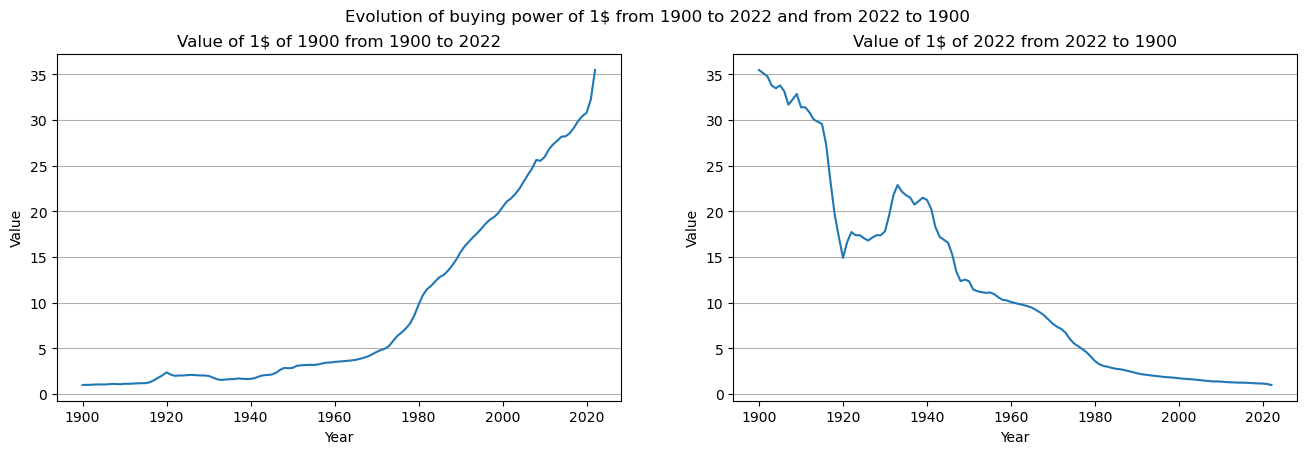

In [97]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4.5))

fig.suptitle('Evolution of buying power of 1$ from 1900 to 2022 and from 2022 to 1900')

ax[0].plot(inflation['amount_1900'])
ax[0].set_title('Value of 1$ of 1900 from 1900 to 2022')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Value')
ax[0].grid(axis='y')


# plot from 2022 to 1900
ax[1].plot(inflation.index, inflation['amount_2022'].values)
ax[1].set_title('Value of 1$ of 2022 from 2022 to 1900')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Value')
ax[1].grid(axis='y')
plt.show()

In the following cell, we create two new columns:
* `box_office_inflation`: the box office revenue adjusted for inflation
* `budget_inflation`: the budget adjusted for inflation
   
We will use these two columns rather than `box_office_revenue` and `budget` for the rest of the analyis.

In [ ]:
# adjust box office for inflation
def add_inflation_data(movies, inflation):
    def inflation_adjustment(row, column):
        if np.isnan(row[column]):
            return np.nan
            
        return row[column] * inflation.loc[row['release_date'].year, 'amount_2022']
    
    movies['box_office_inflation'] = movies.apply(lambda x: inflation_adjustment(x, 'box_office_revenue'), axis=1)
    movies['budget_inflation'] = movies.apply(lambda x: inflation_adjustment(x, 'budget'), axis=1)

    return movies


movies = add_inflation_data(movies, inflation)

# Data exploration:  missing values
The CMU movies dataset contains a lot of missing values. In order to asses the usability of our dataset, we need to make sure that there's enough movies that have values for the features of interest. 
The results are that 7704 movies have a box office information and 4604 of them have a budget information. We define this dataset size as large enough for our analysis.

In [161]:
# number of nan box office values

nb_nan_movies = movies['box_office_revenue'].isna().sum()
print('Number of known box office values: {} ({:.2%})'.format(movies.shape[0] - nb_nan_movies, (movies.shape[0] - nb_nan_movies) / movies.shape[0]))
print('Number of nan box office values: {} ({:.2%})'.format(nb_nan_movies, nb_nan_movies / movies_cmu.shape[0]))

nb_non_nan_movies = movies_cmu.shape[0] - nb_nan_movies
nb_non_nan_merged_movies = movies.shape[0] - nb_nan_movies
print('Number of box office values gained with kaggle: {} ({:.2%})'.format(nb_non_nan_merged_movies - nb_non_nan_movies, (nb_non_nan_merged_movies - nb_non_nan_movies) / nb_non_nan_movies))

Number of known box office values: 7704 (100.00%)
Number of nan box office values: 0 (0.00%)
Number of box office values gained with kaggle: -26704 (-77.61%)


In [99]:
# number of nan release date values

nb_nan_movies = movies['release_date'].isna().sum()
print('Number of known release date values: {} ({:.2%})'.format(movies.shape[0] - nb_nan_movies, (movies.shape[0] - nb_nan_movies) / movies.shape[0]))
print('Number of nan release date values: {} ({:.2%})'.format(nb_nan_movies, nb_nan_movies / movies.shape[0]))

Number of known release date values: 33220 (96.48%)
Number of nan release date values: 1211 (3.52%)


In [100]:
# number of nan budget values

nb_nan_movies = movies['budget'].isna().sum()
print('Number of known budget values: {} ({:.2%})'.format(movies.shape[0] - nb_nan_movies, (movies.shape[0] - nb_nan_movies) / movies.shape[0]))
print('Number of nan budget values: {} ({:.2%})'.format(nb_nan_movies, nb_nan_movies / movies.shape[0]))

Number of known budget values: 4604 (13.37%)
Number of nan budget values: 29827 (86.63%)


### Keep only movies with box office revenue
Because our analysis is focused on the box office revenue, we will only keep the movies for which we have a box office revenue.

In [162]:
movies = movies[movies['box_office_revenue'].notna()]
print('We still have {} movies after droping the movies with no box office revenue.'.format(movies.shape[0]))

We still have 7704 movies after droping the movies with no box office revenue


In the following cells, we see that the movies have almost all a release date too. Because there's only 13 movies for which the release that is not provided, we will add this information by hand. The dates added by hand have been found on the Wikipedia article of each movie.

In [103]:
# number of nan release date values

nb_nan_movies = movies['release_date'].isna().sum()
print('Number of known release date values: {} ({:.2%})'.format(movies.shape[0] - nb_nan_movies, (movies.shape[0] - nb_nan_movies) / movies.shape[0]))
print('Number of nan release date values: {} ({:.2%})'.format(nb_nan_movies, nb_nan_movies / movies.shape[0]))

Number of known release date values: 7691 (99.83%)
Number of nan release date values: 13 (0.17%)


In [104]:
# Number of budget values

nb_nan_movies = movies['budget'].isna().sum()
print('Number of known release date values: {} ({:.2%})'.format(movies.shape[0] - nb_nan_movies, (movies.shape[0] - nb_nan_movies) / movies.shape[0]))
print('Number of nan release date values: {} ({:.2%})'.format(nb_nan_movies, nb_nan_movies / movies.shape[0]))

Number of known release date values: 3846 (49.92%)
Number of nan release date values: 3858 (50.08%)


In [106]:
# Add the missing dates. The dates are taken from wikipedia.

def add_missing_release_date(movies):
    """
        Add release date for specific entries
    """
    missing_release_dates = {
        'The Impossible': '2012-10-11',
        'The Outing': '1987-09-11',
        'Into the Spider\'s Web': '2007-08-26',
        'Melissa P.': '2005-11-18',
        'The Lamp': '2011-08-01',
        'The Bear': '1988-10-19',
        'Meatballs III: Summer Job': '1987-02-21',
        'The Steel Trap': '1952-11-12',
        'Angels Die Hard': '1970-06-01',
        'American Cyborg: Steel Warrior': '1994-01-07', 
        'Shattered Image': '1998-12-04',
        'The Ghost of Slumber Mountain': '1918-11-17',
        'Iron Warrior': '1987-01-09'
    }

    for movie_name, release_date in missing_release_dates.items():
        movies.loc[movies['name'] == movie_name, 'release_date'] = pd.to_datetime(release_date)

    return movies

add_missing_release_date(movies)

assert(movies['release_date'].isna().sum() == 0)

# Define decades
As we ought to understand which features influence the box office revenue, we need to see how the different variables evolves over time. To do so, we will add a decade column in the movie dataset.

In [ ]:
movies['release_decade'] = movies['release_date'].dt.year // 10 * 10
movies['release_half_decade'] = movies['release_date'].dt.year // 5 * 5

# Data exploration: box office revenue and the budget
In the following cells, we compare the evolution of the movies box office revenue based on different values: 
* The average box office revenue for each year, with and without inflation
* The largest box office revenue for each year, with and without inflation

And the evolution of the budgets:
* The average budget for each year, with and without inflation
* The largest budget for each year, with and without inflation

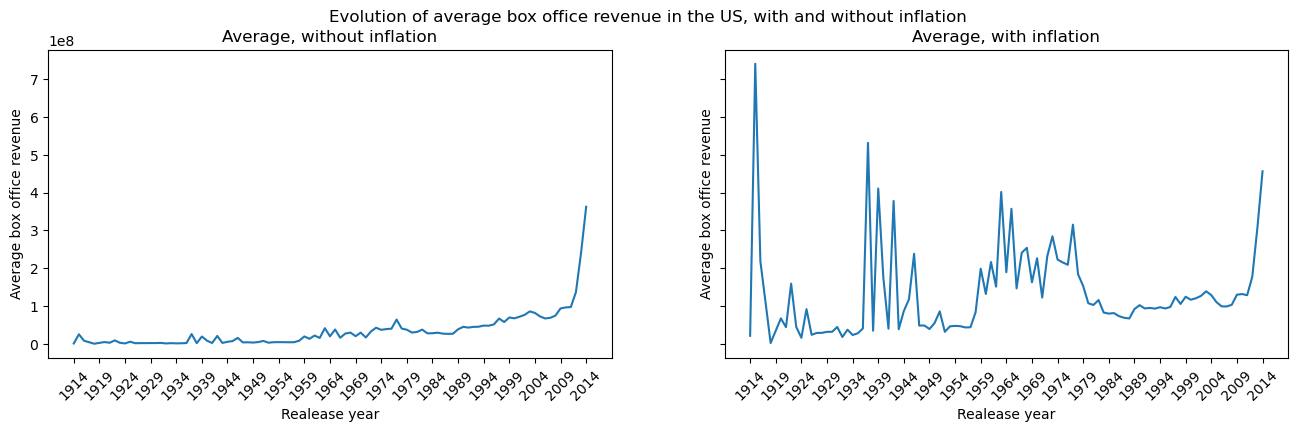

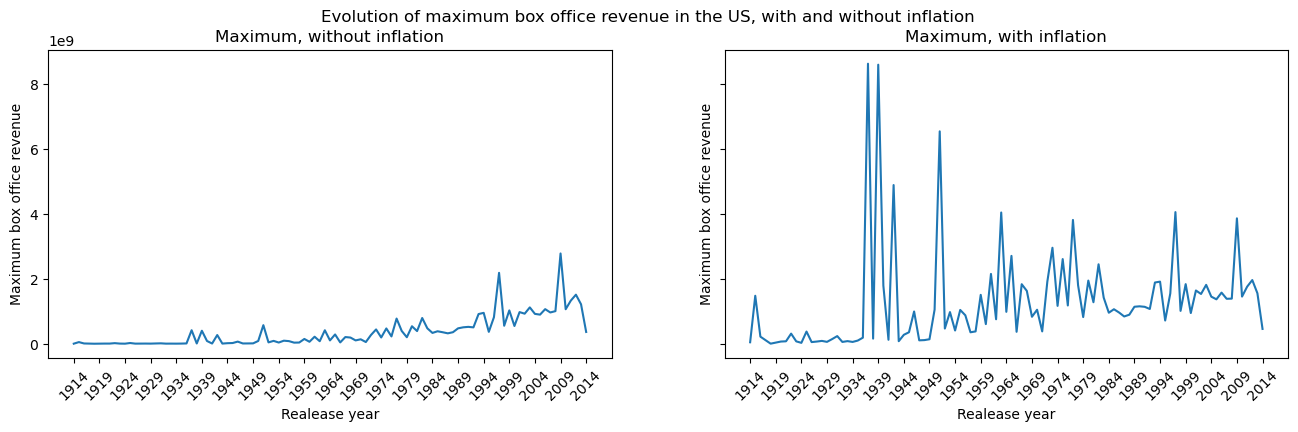

In [108]:
# plot box office revenue with and without inflation

def plot_over_years(df, ax, column, metrics, title, ylabel):   
    """
        Plot the given column over the years
        metrics: 'mean' or 'max'
    """ 
    ax.plot(df[column][metrics])
    ax.set_title(title)
    ax.set_xlabel('Realease year')
    ax.set_ylabel(ylabel)

    plt.sca(ax)
    plt.xticks(np.arange(1914, 2015, 5), rotation=45) # np.arange(1914, 2015, 5), 


box_office_year = movies.groupby(movies['release_date'].dt.year)[['box_office_revenue', 'box_office_inflation']].agg(['mean', 'max']).sort_index()


# Average
fig, ax = plt.subplots(1, 2, figsize=(16, 4), sharex=True, sharey=True)

fig.suptitle('Evolution of average box office revenue in the US, with and without inflation')

plot_over_years(box_office_year, ax[0], 'box_office_revenue', 'mean', 'Average, without inflation', 'Average box office revenue')
plot_over_years(box_office_year, ax[1], 'box_office_inflation', 'mean','Average, with inflation', 'Average box office revenue')

plt.show()

# Maximum
fig, ax = plt.subplots(1, 2, figsize=(16, 4), sharex=True, sharey=True)

fig.suptitle('Evolution of maximum box office revenue in the US, with and without inflation')

plot_over_years(box_office_year, ax[0], 'box_office_revenue', 'max','Maximum, without inflation', 'Maximum box office revenue')
plot_over_years(box_office_year, ax[1], 'box_office_inflation', 'max','Maximum, with inflation', 'Maximum box office revenue')

plt.show()

Top 10 movies with the highest box office revenue in the US, with and without inflation

In [109]:
# store them to compare them with the budget
top_10_bo = movies.sort_values(by='box_office_inflation', ascending=False)[['name', 'release_date', 'box_office_revenue', 'box_office_inflation', 'budget', 'budget_inflation']].head(10)

movies.sort_values(by='box_office_inflation', ascending=False)[['name', 'release_date', 'box_office_revenue', 'box_office_inflation', 'budget', 'budget_inflation']].head(10)

,name,release_date,box_office_revenue,box_office_inflation,budget,budget_inflation
5056,Snow White and the Seven Dwarfs,1937-12-21,4.160000e+08,8.631392e+09,1488423.0,3.088260e+07
15981,Gone with the Wind,1939-12-15,4.000000e+08,8.601212e+09,4000000.0,8.601212e+07
23794,Alice in Wonderland,1951-07-26,5.720000e+08,6.546632e+09,3000000.0,3.433548e+07
524,Bambi,1942-08-08,2.674472e+08,4.891250e+09,858000.0,1.569167e+07
9403,Titanic,1997-11-01,2.185372e+09,4.057405e+09,200000000.0,3.713239e+08
2971,Love with the Proper Stranger,1963-12-25,4.150049e+08,4.045157e+09,NaN,NaN
10025,Avatar,2009-12-10,2.782275e+09,3.865118e+09,237000000.0,3.292388e+08
34033,Star Wars Episode IV: A New Hope,1977-05-25,7.753980e+08,3.815689e+09,NaN,NaN
9984,The Exorcist,1973-06-19,4.410710e+08,2.958261e+09,8000000.0,5.365595e+07
18394,The Sound of Music,1965-03-02,2.862143e+08,2.707969e+09,8200000.0,7.758293e+07


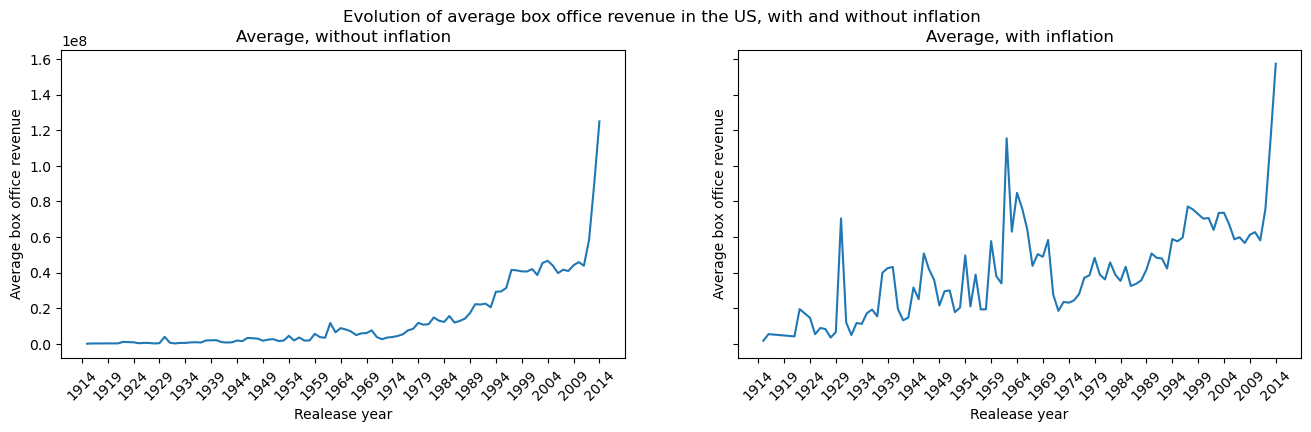

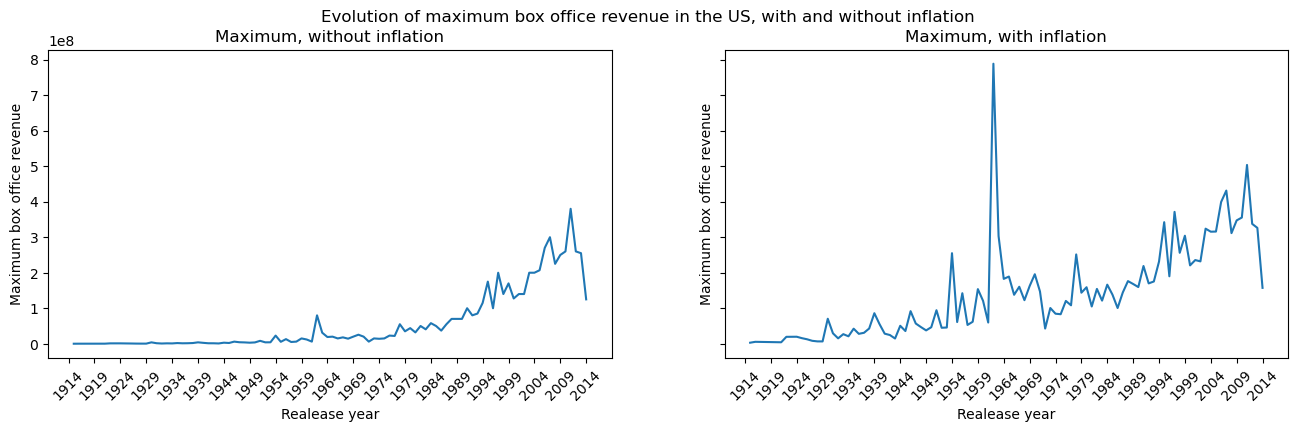

In [110]:
# plot budget with and without inflation

revenue_year = movies[movies['budget'].notna()].groupby(movies['release_date'].dt.year)[['budget', 'budget_inflation']].agg(['mean', 'max']).sort_index()

# Average
fig, ax = plt.subplots(1, 2, figsize=(16, 4), sharex=True, sharey=True)

fig.suptitle('Evolution of average box office revenue in the US, with and without inflation')

plot_over_years(revenue_year, ax[0], 'budget', 'mean', 'Average, without inflation', 'Average box office revenue')
plot_over_years(revenue_year, ax[1], 'budget_inflation', 'mean','Average, with inflation', 'Average box office revenue')

plt.show()

# Maximum
fig, ax = plt.subplots(1, 2, figsize=(16, 4), sharex=True, sharey=True)

fig.suptitle('Evolution of maximum box office revenue in the US, with and without inflation')

plot_over_years(revenue_year, ax[0], 'budget', 'max','Maximum, without inflation', 'Maximum box office revenue')
plot_over_years(revenue_year, ax[1], 'budget_inflation', 'max','Maximum, with inflation', 'Maximum box office revenue')

plt.show()

Top 10 movies with the highest box office revenue in the US, with and without inflation

In [111]:
top_10_budget = movies.sort_values(by='budget_inflation', ascending=False)[['name', 'release_date', 'box_office_revenue', 'box_office_inflation', 'budget', 'budget_inflation']].head(10)

movies.sort_values(by='budget_inflation', ascending=False)[['name', 'release_date', 'box_office_revenue', 'box_office_inflation', 'budget', 'budget_inflation']].head(10)

,name,release_date,box_office_revenue,box_office_inflation,budget,budget_inflation
25341,The Manchurian Candidate,1962-10-24,7.716923e+06,7.605456e+07,80000000.0,7.884444e+08
5987,Pirates of the Caribbean: On Stranger Tides,2011-05-07,1.043872e+09,1.382994e+09,380000000.0,5.034503e+08
30993,Pirates of the Caribbean: At World's End,2007-05-19,9.634204e+08,1.385014e+09,300000000.0,4.312804e+08
18355,Superman Returns,2006-06-21,3.910812e+08,5.781484e+08,270000000.0,3.991500e+08
9403,Titanic,1997-11-01,2.185372e+09,4.057405e+09,200000000.0,3.713239e+08
13763,Spider-Man 3,2007-04-16,8.908716e+08,1.280718e+09,258000000.0,3.709011e+08
32287,Tangled,2010-11-24,5.907219e+08,8.073503e+08,260000000.0,3.553467e+08
3067,Harry Potter and the Half-Blood Prince,2009-07-06,9.344165e+08,1.298085e+09,250000000.0,3.472984e+08
24098,Waterworld,1995-07-28,2.642182e+08,5.167840e+08,175000000.0,3.422822e+08
27100,John Carter,2012-03-08,2.827781e+08,3.671045e+08,260000000.0,3.375338e+08


In [112]:
print("Movies within the top 10 highest budget and highest box office revenue:")
movies.loc[top_10_bo.index.intersection(top_10_budget.index)][['name', 'release_date', 'box_office_revenue', 'box_office_inflation', 'budget', 'budget_inflation']]

Movies within the top 10 highest budget and highest box office revenue:


,name,release_date,box_office_revenue,box_office_inflation,budget,budget_inflation
9403,Titanic,1997-11-01,2.185372e+09,4.057405e+09,200000000.0,3.713239e+08


# Data exploration: number of movies per year
Here, we plot the distribution of the number of movies produced every year

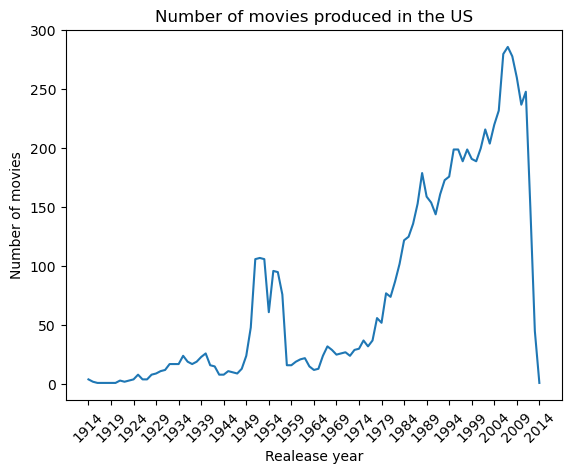

In [113]:
# plot the distribution of the number of movies produced each year
nb_movies_year = movies['release_date'].dt.year.value_counts().sort_index()


nb_movies_year.plot(legend=False)

plt.title('Number of movies produced in the US')
plt.xlabel('Realease year')
plt.ylabel('Number of movies')

# plt.grid(axis='y', color='grey', linestyle='--', alpha=0.5)
# for i in range(1914, 2015, 5):
#     plt.axvline(i, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.arange(1914, 2015, 5), rotation=45)

plt.show()

# Load characters
In the following section, we load the characters dataset, and add the ethnicity information for each character. It is necessary to load this dataset because we will be able to compute many statistics from it (for instance, gender ratio).

In [114]:
# load the characters dataset

def load_characters(character_file):
    """
        Load character dataset
    """
    character_columns = ['wiki_movie_id', 'freebase_movie_id', 'm_release_date', 'name', 'a_dob', 'a_gender', 'a_height', 'a_ethnicity_freebase_id', 'a_name', 'a_age_at_release', 'freebase_char/a_map', 'freebase_char_id', 'freebase_a_id']
    characters = pd.read_csv(character_file, sep='\t', names=character_columns, index_col=False)

    # convert date string to datetime objects
    characters['m_release_date'] = pd.to_datetime(characters['m_release_date'], format='%Y-%m-%d', errors='coerce')

    # drop useless columns
    characters = characters.drop(['freebase_char/a_map', 'freebase_char_id', 'freebase_a_id'], axis=1)

    return characters


characters = load_characters(CHARACTERS_FILE)
print(characters.shape)
characters.head()

(450669, 10)


,wiki_movie_id,freebase_movie_id,m_release_date,name,a_dob,a_gender,a_height,a_ethnicity_freebase_id,a_name,a_age_at_release
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0


## Load ethnicities
In the following cell, we load the ethnicities and add the ethnicity information to every character in the dataframe.  
By doing so, every character row will contain its ethnicity name (if available).  
The different ethnicites are:
* 1 : White
* 2 : Black / African American
* 3 : Asian
* 4 : American Indian / Alaska Native
* 5 : Native Hawaiian / Other Pacific Islander
* 6 : Other (e.g. Aboriginal/Indigenous Australien)
  
Every ethicity is followed by another encoding, defined with + or -:
* \- : Not Hispanic or Latino
* \+ : Hispanic or Latino

This list of ethnicities has been generated based on the official U.S. xxx TODO fill it [link](link)

In [115]:
# load ethnicites

def load_ethnicities(ethnicity_file, etchnicity_clusters):
    """
        Load ethnicities dataset and add clusters

        Clusters:
        {1: 'White', 
         2: 'Black / African American', 
         3: 'Asian', 
         4: 'American Indian / Alaska Native', 
         5: 'Native Hawaiian / Other Pacific Islander',
         6: 'Other'}
    """
    ethnicities = pd.read_csv(ethnicity_file, sep='\t', header=None, names=['freebase_ethnicity_id', 'ethnicity_name', 'cluster_id', 'is_hispanic'])

    ethnicities['ethnicity_cluster_name'] = ethnicities['cluster_id'].map(etchnicity_clusters)
    ethnicities['is_hispanic'] = ethnicities['is_hispanic'].map({'-': 0, '+': 1}).astype(int)

    return ethnicities


ethnicities = load_ethnicities(ETHNICITY_FILE, ETHNICITY_CLUSTERS)
ethnicities.head()

,freebase_ethnicity_id,ethnicity_name,cluster_id,is_hispanic,ethnicity_cluster_name
0,/m/0x67,African Americans,2,0,Black / African American
1,/m/064b9n,Omaha people,4,0,American Indian / Alaska Native
2,/m/041rx,Jewish people,1,0,White
3,/m/033tf_,Irish Americans,1,0,White
4,/m/04gfy7,Indian Americans,3,0,Asian


In [116]:
# add ethnicities in the characters dataframe

def add_characters_ethnicities(characters, ethnicities):
    """
        Add ethnicities name in the characters dataframe
    """
    df = characters.copy()
    df = pd.merge(left=characters, right=ethnicities, left_on='a_ethnicity_freebase_id', right_on='freebase_ethnicity_id', how='left')
    df = df.drop(['a_ethnicity_freebase_id', 'freebase_ethnicity_id', 'ethnicity_name', 'cluster_id'], axis=1)
    df = df.rename(columns={'ethnicity_cluster_name': 'a_ethnicity', 'is_hispanic': 'a_is_hispanic'})

    return df


characters = add_characters_ethnicities(characters, ethnicities)
characters.head()

,wiki_movie_id,freebase_movie_id,m_release_date,name,a_dob,a_gender,a_height,a_name,a_age_at_release,a_is_hispanic,a_ethnicity
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,Wanda De Jesus,42.0,NaN,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,Natasha Henstridge,27.0,NaN,NaN
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,Ice Cube,32.0,0.0,Black / African American
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,Jason Statham,33.0,NaN,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,Clea DuVall,23.0,NaN,NaN


# Add characters for every movie
In order to compute statistics based on the movies characters, we will merge (left join) the movies dataframe and the characters dataframe. This is done in the following cell.  
The dataframe containing the movies merged with the characters is instaciated as `df` and will be frequently used during the rest of this notebook.

In [117]:
# merge characters and movies
def merge_characters_movies(characters, movies):
    """
        Merge the characters and the movies dataset.
        Left join on movies using wiki_movie_id
    """
    # Movies and characters
    df = pd.merge(left=characters, right=movies, on='wiki_movie_id', how='right', suffixes=('_c', '_m'))

    # clean features
    duplicate_columns = ['freebase_movie_id_c', 'release_date']
    df = df.drop(duplicate_columns, axis=1)
    df = df.rename(columns={'freebase_movie_id_m': 'freebase_movie_id', 'name_c': 'char_name', 'name_m': 'movie_name', 'm_release_date': 'release_date'})

    # change order of columns
    df = df[['wiki_movie_id', 
            'freebase_movie_id', 'movie_name', 'release_date', 
            'box_office_revenue', 'box_office_inflation',
            'budget', 'budget_inflation', 'runtime', 'genres',
            'languages', 'countries', 'char_name', 'a_name', 
            'a_gender', 'a_ethnicity', 'a_is_hispanic', 'a_dob', 'a_age_at_release', 
            'a_height', 'vote_count', 'vote_average']]

    return df


df = merge_characters_movies(characters, movies)

print('The dataset contains: {} rows'.format(df.shape[0]))
df.head(3)

The dataset contains: 96559 rows


,wiki_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,box_office_inflation,budget,budget_inflation,runtime,genres,...,char_name,a_name,a_gender,a_ethnicity,a_is_hispanic,a_dob,a_age_at_release,a_height,vote_count,vote_average
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,2.358180e+07,28000000.0,4.712713e+07,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",...,Akooshay,Wanda De Jesus,F,NaN,NaN,1958-08-26,42.0,1.620,299.0,4.8
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,2.358180e+07,28000000.0,4.712713e+07,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",...,Lieutenant Melanie Ballard,Natasha Henstridge,F,NaN,NaN,1974-08-15,27.0,1.780,299.0,4.8
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,2.358180e+07,28000000.0,4.712713e+07,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",...,Desolation Williams,Ice Cube,M,Black / African American,0.0,1969-06-15,32.0,1.727,299.0,4.8


# Compute stats on the movies features
Now that we have added characters information for every movie, we will compute statistics about these characters. We need to find meaningul statistics in order to represent the movies population in the best way possible. We will then use these statistics to detect trends between the characters of a movie and the box office revenue.  
Statistics are computed on:
* The actors age (age at release)
* The actos height
* The actors gender
* The actors ethnicity

## Compute gender stats

In [120]:
# Compute stats on gender
# At the moment, set the ratio to one if the denominator is zero

def add_gender_stats(df, movies):
    """
        Compute and append the gender stats as new columns in the movies dataset
    """
    def compute_men_women_ratio(x):
        genders = x['a_gender']
        nb_actors = x['a_name'].count()
        nb_male = genders[genders == 'M'].count()
        nb_female = genders[genders == 'F'].count()
        nb_nan_gender = genders.isna().sum()

        nb_known_gender = nb_known_gender=nb_male+nb_female
        m_f_ratio = nb_male / nb_female if nb_female > 0 else 1 if nb_male > 0 else 0
        m_ratio = nb_male / nb_known_gender if nb_known_gender > 0 else 0
        f_ratio = nb_female / nb_known_gender  if nb_known_gender > 0 else 0
        nan_ratio = nb_nan_gender / x.shape[0]

        return pd.Series(index=['nb_actors', 'nb_male', 'nb_female', 'nb_nan_gender', 'm_ratio', 'f_ratio', 'M_F_ratio', 'nan_ratio'], data=[nb_actors, nb_male, nb_female, nb_nan_gender, m_ratio, f_ratio, m_f_ratio, nan_ratio])

    # compute stats
    df_gender = df.groupby('wiki_movie_id').apply(compute_men_women_ratio)

    df_gender['nb_actors'] = df_gender['nb_actors'].astype(int)
    df_gender['nb_male'] = df_gender['nb_male'].astype(int)
    df_gender['nb_female'] = df_gender['nb_female'].astype(int)
    df_gender['nb_nan_gender'] = df_gender['nb_nan_gender'].astype(int)

    return pd.merge(left=movies, right=df_gender, on='wiki_movie_id', how='left', suffixes=('_m', '_g'))

movies = add_gender_stats(df, movies)
movies.head(3)

,wiki_movie_id,freebase_movie_id,name,release_date,box_office_revenue,runtime,languages,countries,genres,budget,...,box_office_inflation,budget_inflation,nb_actors,nb_male,nb_female,nb_nan_gender,m_ratio,f_ratio,M_F_ratio,nan_ratio
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",28000000.0,...,2.358180e+07,4.712713e+07,17,11,6,0,0.647059,0.352941,1.833333,0.0
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",2000000.0,...,7.602857e+07,4.223810e+07,4,2,2,0,0.500000,0.500000,1.000000,0.0
2,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,[English Language],[United States of America],"[Children's/Family, Musical, Fantasy, Comedy, ...",6000000.0,...,9.833703e+08,5.769106e+07,13,7,6,0,0.538462,0.461538,1.166667,0.0


## Compute age stats

In [121]:
def add_age_height_weight_stats(df, movies):
    """
        Compute and append the age and height stats as new columns in the movies dataset
    """
    num_columns = ['a_age_at_release', 'a_height']

    movies_stats = df.groupby('wiki_movie_id')[num_columns].agg({
        'a_age_at_release': ['mean', 'std'], 
        'a_height': ['mean', 'std']
        })

    movies_stats.columns = ["_".join(col)for col in movies_stats.columns.to_flat_index()]

    return pd.merge(left=movies, right=movies_stats, on='wiki_movie_id', how='left', suffixes=('_m', '_s'))

movies = add_age_height_weight_stats(df, movies)

## Computer ethnicity stats

In [122]:
def add_ethnicity_stats(df, movies):
    """
        Compute and append the ethnicity stats as new columns in the movies dataset
    """
    def compute_ehtnicites_ratio(x):
        ethnicities = x['a_ethnicity']
        ehnicities_list = x['a_ethnicity'].dropna().unique()

        eth_stats = {}
        nb_known_ethnicities = ethnicities.notna().sum() # use a counter

        for ethnicity in ETHNICITY_CLUSTERS.values():
            add_undercore = lambda column: '_'.join(column.replace('/', '').split(' ')).replace('__', '_').lower()
            eth_stats[f'{add_undercore(ethnicity)}_hispanic_ratio'] = ethnicities[(ethnicities == ethnicity) & (x['a_is_hispanic'] == 1)].count() / nb_known_ethnicities if nb_known_ethnicities != 0 else np.nan
            eth_stats[f'{add_undercore(ethnicity)}_not_hispanic_ratio'] = ethnicities[(ethnicities == ethnicity) & (x['a_is_hispanic'] == 0)].count() / nb_known_ethnicities if nb_known_ethnicities != 0 else np.nan

            # count the value of both hispanic and not hispanic together
            eth_stats[f'{add_undercore(ethnicity)}_ratio'] = ethnicities[ethnicities == ethnicity].count() / nb_known_ethnicities if nb_known_ethnicities != 0 else np.nan

        return pd.Series(eth_stats)

    df_ethnicity = df.groupby('wiki_movie_id').apply(compute_ehtnicites_ratio)

    return pd.merge(left=movies, right=df_ethnicity, on='wiki_movie_id', how='left', suffixes=('_m', '_g'))

movies = add_ethnicity_stats(df, movies)
movies.head(3)

,wiki_movie_id,freebase_movie_id,name,release_date,box_office_revenue,runtime,languages,countries,genres,budget,...,asian_ratio,american_indian_alaska_native_hispanic_ratio,american_indian_alaska_native_not_hispanic_ratio,american_indian_alaska_native_ratio,native_hawaiian_other_pacific_islander_hispanic_ratio,native_hawaiian_other_pacific_islander_not_hispanic_ratio,native_hawaiian_other_pacific_islander_ratio,other_hispanic_ratio,other_not_hispanic_ratio,other_ratio
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",28000000.0,...,0.0,0.0,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",2000000.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,[English Language],[United States of America],"[Children's/Family, Musical, Fantasy, Comedy, ...",6000000.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


# Data exploration: analyse the relationship based on 'trends'
In the following section, we aim to analyse the trends between the box office revenue and the different movies properties, using the appropriated plots.

## Distribution of the box office revenue

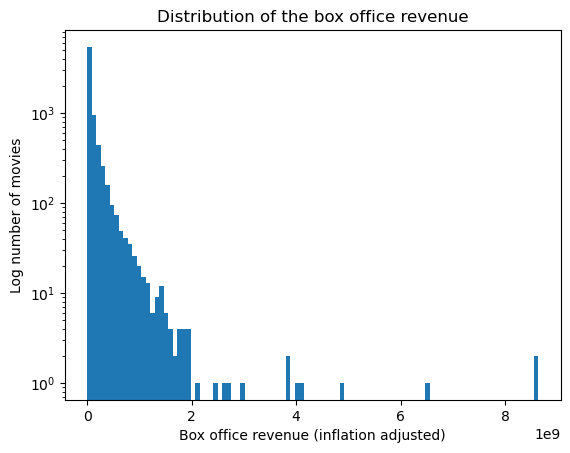

In [165]:
main_column = 'box_office_inflation'

# plot the distribution of the box office revenue
movies[main_column].plot(kind='hist', bins=100, legend=False, logy=True)
plt.title('Distribution of the box office revenue')
plt.xlabel('Box office revenue (inflation adjusted)')
plt.ylabel('Log number of movies')
plt.show()

# Which characteristics of movies are causing high movie box office revenue?
In the following cell, we generate a graph which tries to answer the following question: which characteristics of movies are causing high movie box office revenue?  
We have to keep in mind that we only show a trends between the box office and the other columns of interest. However, this doesn't not means that there's a causation between the two columns, even if the trends suggests that one implies the other! Moreover, this graph presents the whole dataset, and not the trends between the different decades. In order to do a more scientific analysis, we investigate the trends using pair matching further in this notebook.

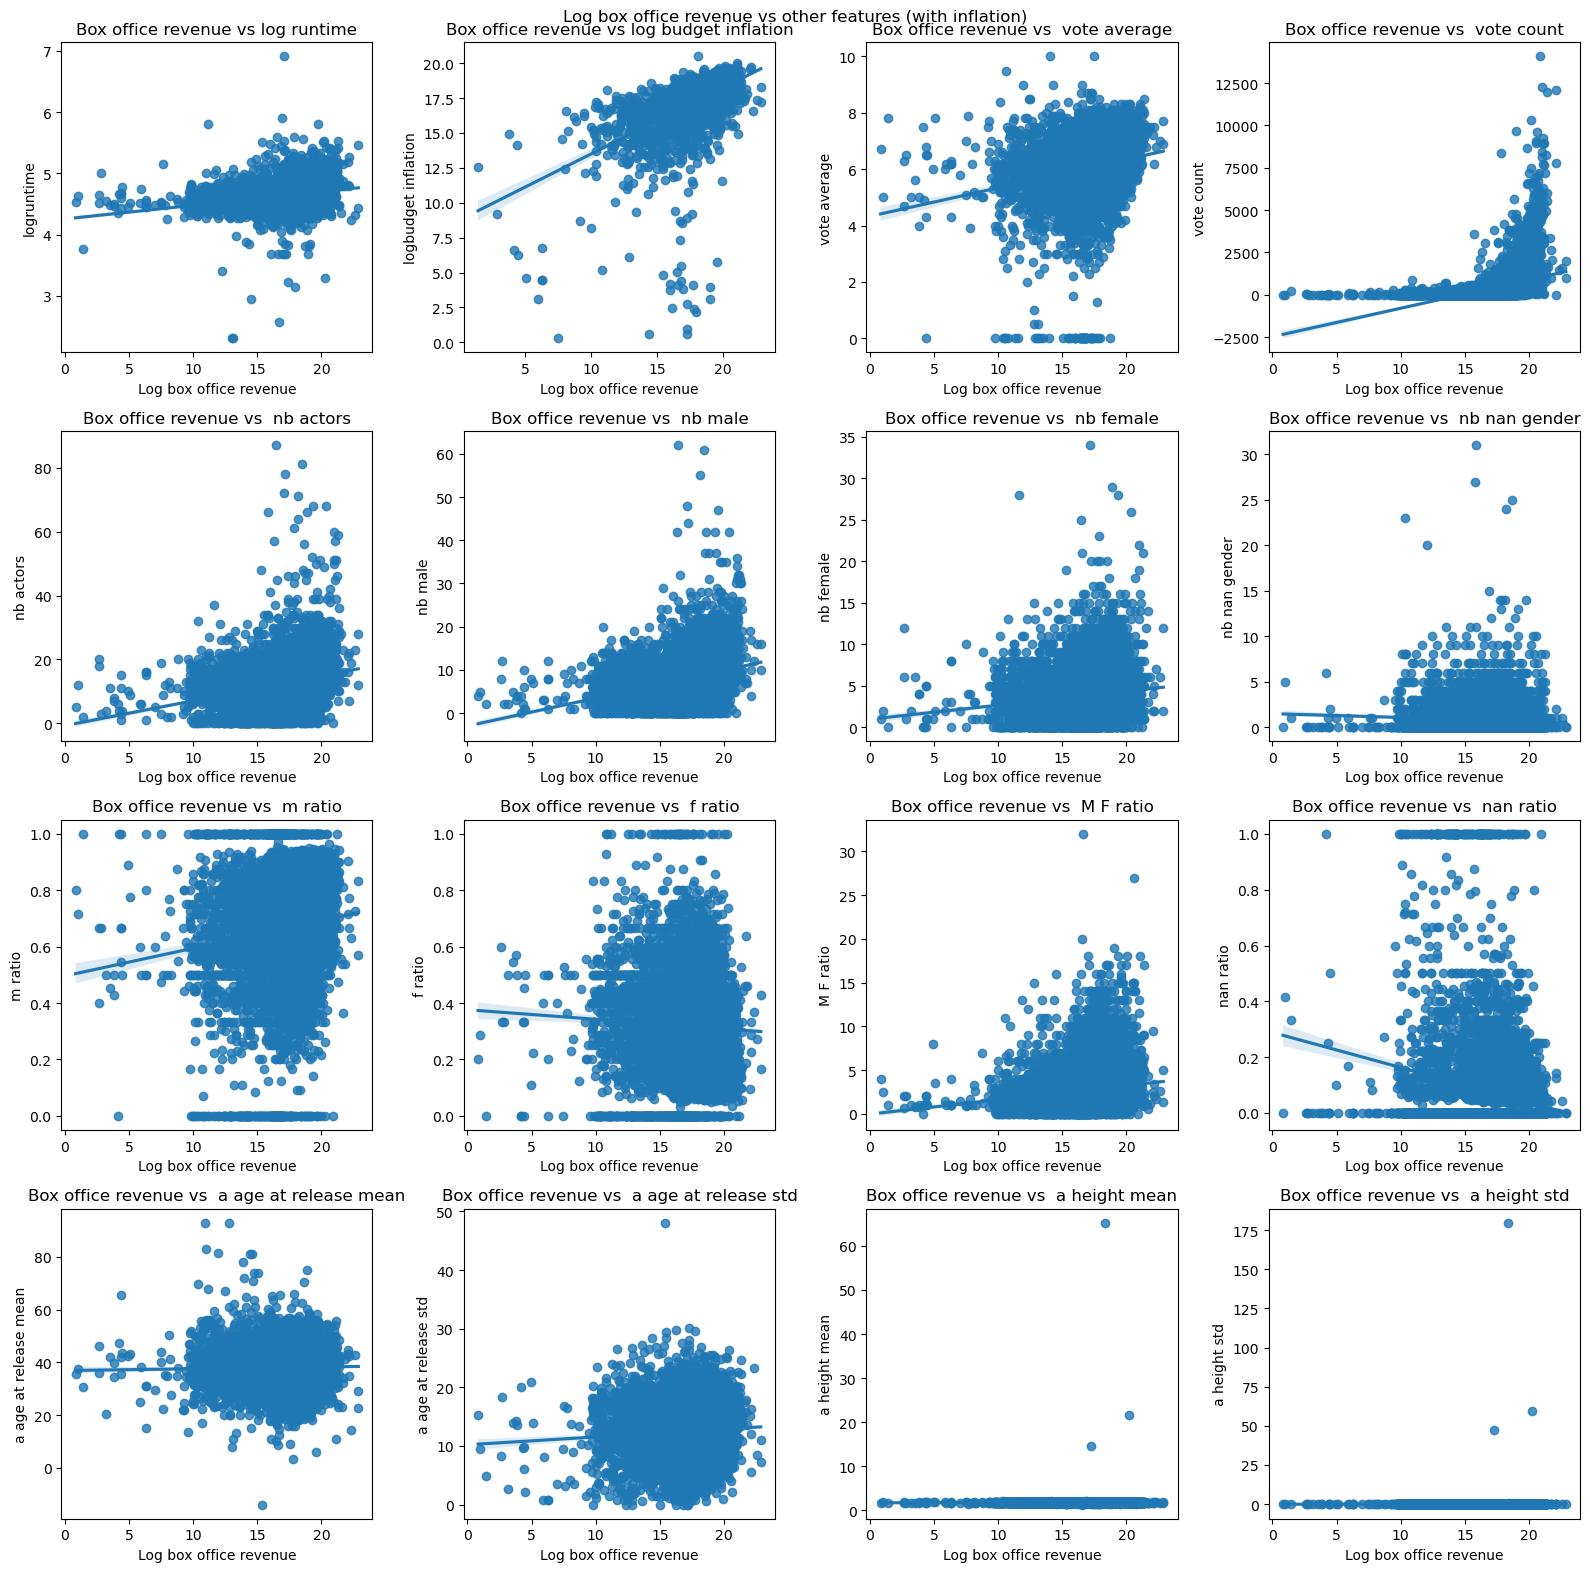

In [174]:
movies_tmp = movies.copy()

columns_of_interest = ['runtime', 'budget_inflation', 'vote_average', 'vote_count', 
        'nb_actors', 'nb_male', 'nb_female', 'nb_nan_gender', 'm_ratio', 'f_ratio', 
        'M_F_ratio', 'nan_ratio', 'a_age_at_release_mean', 'a_age_at_release_std', 
        'a_height_mean', 'a_height_std']

fig, ax = plt.subplots(len(columns_of_interest)//4, 4, figsize=(16, 16))
ax = ax.flatten()

fig.suptitle('Log box office revenue vs other features (with inflation)')

plot_fct = sns.regplot

log_columns = ['runtime', 'budget_inflation']

movies_tmp[main_column] = np.log(movies_tmp[main_column])
for i, column in enumerate(columns_of_interest):
    if column in log_columns:
        movies_tmp[column] = np.log(movies_tmp[column])

    plot_fct(data=movies_tmp, x=main_column, y=column, ax=ax[i], fit_reg=True) #  , scatter_kws={'alpha':0.15}

    display_name = ' '.join(column.split('_'))
    ax[i].set_title('Box office revenue vs {} {}'.format('' if column not in log_columns else 'log', display_name))
    ax[i].set_xlabel('Log box office revenue')
    ax[i].set_ylabel(str('' if column not in log_columns else 'log ') + display_name)

plt.tight_layout()
plt.show()

In [175]:
# select the columns that you want to study
columns_of_interest = ['runtime', 'budget_inflation', 'vote_average', 'vote_count', 'a_age_at_release_mean']

main_column = 'log_box_office_inflation'
movies['log_box_office_inflation'] = np.log(movies['box_office_inflation'])

# create the interactive figures
fig = go.Figure()

# create one scatter plot of box office revenue vs column
# for each column of interest. Then, link them to the figure
pretty_display = lambda column: ' '.join(column.split('_'))

for column in columns_of_interest: 
    fig.add_trace(
        go.Scatter(
            x = movies[main_column],
            y = movies[column],
            name = pretty_display(column),
            mode = 'markers',
        )
    )

# create the buttons to switch between the different scatter plots
# and link them to the right plot
buttons = []
for column in columns_of_interest:
    buttons.append({
        'label': pretty_display(column),
        'method': 'update',
        'args': [{
            'visible': [c == column for c in columns_of_interest],
            'title': pretty_display(column),      
            'yaxis_title': pretty_display(column),
        }]
    })
    
# add the figure dropdown menu
fig.update_layout(
    updatemenus=[go.layout.Updatemenu(
        buttons=buttons,
        showactive=True
        )
    ],
    xaxis_title='Log box office revenue',
    width=1200,
    )

fig.show()

## Impact of the genre

In order to analyze the evolution of the representation over different decades, we will first create a new column that will contain the decade of the movie. In order to compare the genres, we select the percentage of each genre in the top 10 movies of each decade.

In [130]:
# Create the dataframe containing the top 10 movies per decade
largest_index = movies.groupby('release_decade')['box_office_inflation'].nlargest(20)
largest_index = largest_index.reset_index(level=1).rename(columns={'level_1':'index'})

top_movies = movies[movies.index.isin(largest_index['index'])].sort_values('release_decade')
print(top_movies.shape)
top_movies.head(3)

Get the 10 most represented genre over the whole dataset (most represented = number of movies in which they are present)

In [131]:
from collections import Counter

genre_list = (genre for genre_list in movies['genres'].values for genre in genre_list)
genre_counter = Counter(genre_list)
genre_counter = dict(genre_counter.most_common(10))
genre_counter

{'Drama': 3836,
 'Comedy': 3049,
 'Thriller': 1896,
 'Romance Film': 1841,
 'Action': 1727,
 'Action/Adventure': 1352,
 'Crime Fiction': 1241,
 'Adventure': 1139,
 'Indie': 1061,
 'Romantic comedy': 866}

In [134]:
# Prepare the main dataset which will contain the information for every genre
main_column = 'box_office_inflation'

df_global_genre = pd.DataFrame()
for i, (genre, count) in enumerate(genre_counter.items()):
    # get the number of movies from this genre for each decade
    genre_df = top_movies[top_movies['genres'].apply(lambda x: genre in x)].groupby('release_decade')['wiki_movie_id'].count()

    # divide it by the total revenue of the decade to compute the percentage
    genre_df = genre_df / top_movies.groupby('release_decade')['wiki_movie_id'].count()
    genre_df = genre_df.rename(genre)

    df_global_genre = pd.concat((df_global_genre, genre_df), axis=1)


In [185]:
# the evolution of every genre ratio
df_plot = df_global_genre.reset_index().rename(columns={'index':'release_decade'}).melt(id_vars='release_decade').rename(columns={'value':'ratio', 'variable':'genre'})

fig = px.area(df_plot, x="release_decade", y="ratio", color="genre", line_group="genre")

fig.update_layout(width=1200, title='Evolution of the genre popularity over the decades')
fig.update_xaxes(tickmode='array', tickvals=df_plot['release_decade'].values)
fig.write_html(PLOT_FOLDER + 'box_office_genre_evolution.html')
fig.show()

# Did ethnical diversity in successful movies change over time?

### Box office with inflation for every decade

In [136]:
# Add the metric when there's one!
df_plot = movies.groupby('release_decade')[['box_office_inflation']].mean().reset_index()

fig = px.bar(df_plot, x='release_decade', y='box_office_inflation', color='release_decade')

fig.update_layout(width=1200)
fig.update_xaxes(tickmode='array', tickvals=df_plot['release_decade'].values)
fig.write_html(PLOT_FOLDER + 'box_office_evolution.html')
fig.show()

### Stacked plot for every ethnicity representation over the decades

In [137]:
ethnicity_columns = ['white_ratio', 'black_african_american_ratio', 'asian_ratio', 
       'american_indian_alaska_native_ratio', 'native_hawaiian_other_pacific_islander_ratio', 
       'other_ratio']

       
eth_stats_decades = top_movies.groupby('release_decade')[[main_column] + ethnicity_columns].mean()

df_plot = eth_stats_decades[ethnicity_columns].reset_index().melt(id_vars='release_decade').rename(columns={'value':'percentage', 'variable':'ethnicity'})

fig = px.area(df_plot, x="release_decade", y="percentage", color="ethnicity", line_group="ethnicity")
fig.update_layout(width=1200)
fig.update_xaxes(tickmode='array', tickvals=df_plot['release_decade'].values)

fig.write_html(PLOT_FOLDER + 'ethnicities_evolution.html')
fig.show()

### Radar chart (spider graph)
In such a case, one graph per decade can be interesting!

In [139]:
# Prepare a list of dataframe, one dataframe for each decade.
# Each dataframe of the list contains the ethnicity stats for one decade

eth_global_stats = top_movies[ethnicity_columns].mean()

decades_dfs = []
release_date_column = 'release_decade'
max_ratio = 0
minorities = ['black_african_american_ratio', 'asian_ratio', 'american_indian_alaska_native_ratio', 'native_hawaiian_other_pacific_islander_ratio', 'other_ratio']

for decade in np.sort(movies[release_date_column].unique()):
    # select the movies of the current decade
    decade_movies = top_movies[top_movies[release_date_column] == decade]

    # compute the global stats
    eth_global_stats = decade_movies[minorities].mean()

    # create a df containing the stats for each ethnicity
    decade_df = pd.DataFrame(eth_global_stats).reset_index().rename(columns={'index': 'ethnicity_ratio', 0: 'ratio'})
    
    decades_dfs.append(decade_df)

    decade_max_ratio = decade_df['ratio'].max()
    if decade_max_ratio > max_ratio:
        max_ratio = decade_max_ratio


In [178]:
# plot the decades stats on a spider graph

decades_values = np.sort(movies[release_date_column].unique())

# create the interactive figures
fig = go.Figure()

# create one scatter plot of box office revenue vs column
# for each column of interest. Then, link them to the figure
pretty_display = lambda column: ' '.join(column.split('_'))

for decade_df, decade_value in zip(decades_dfs, decades_values):
    fig.add_trace(
        go.Scatterpolar(
            r=decade_df['ratio'],
            theta=decade_df['ethnicity_ratio'],
            fill='toself',
            name = str(decade_value)
        )
    )
    
# create the buttons to switch between the different scatter plots
# and link them to the right plot
buttons = []

for decade_value in decades_values:
    buttons.append({
        'label': str(decade_value),
        'method': 'update',
        'args': [{
            'visible': [v == decade_value for v in decades_values],
            'title': str(decade_value),
        }]
    })
    

fig.update_layout(
    updatemenus=[go.layout.Updatemenu(
        buttons=buttons,
        showactive=True
        )
    ],
    polar=dict(
        radialaxis=dict(
        visible=True,
        # range=[0, max_ratio]
        )),
    width=1200, height=400,
    showlegend=False
)

fig.write_html(PLOT_FOLDER + 'ethnicities_radar_chart.html', include_plotlyjs='cdn')
fig.show()


# Did the gender ratio of the cast in successful movies change over time?


In [141]:
# create the dataframe contaning information for each gender
plot_df = top_movies.groupby('release_decade')[['m_ratio', 'f_ratio']].mean().reset_index().melt(id_vars='release_decade', value_vars=['m_ratio', 'f_ratio'])
plot_df = plot_df.rename(columns={'variable': 'gender', 'value': 'ratio'})
plot_df['gender'] = plot_df['gender'].apply(lambda x: 'Male' if x == 'm_ratio' else 'Female')

# plot the evolution
fig = px.bar(plot_df, x='release_decade', y='ratio', barmode='group', color='gender')
fig.update_layout(width=1200)
fig.update_xaxes(tickmode='array', tickvals=df_plot['release_decade'].values)

fig.show()

# Did the age distribution of men and women of the cast in successful movies change over time?

In [179]:
# create a stacked plot of the age distribution over each decade
age_columns = ['a_age_at_release_mean', 'a_age_at_release_std']
       
age_stats_decades = top_movies.groupby('release_decade')[age_columns].mean()

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=age_stats_decades.index, y=age_stats_decades['a_age_at_release_mean'],
            name='Age mean'),
    row=1, col=1
)
fig['layout']['yaxis']['title']='Age mean'
fig['layout']['xaxis']['title']='Decades'

fig.add_trace(
    go.Scatter(x=age_stats_decades.index, y=age_stats_decades['a_age_at_release_std'],
        name='Age std'),
    row=1, col=2
)
fig['layout']['yaxis2']['title']='Age std'
fig['layout']['xaxis2']['title']='Decades'

fig.update_layout(width=1200, title="Age statistics over the decades", showlegend=False)
fig.update_xaxes(tickmode='array', tickvals=df_plot['release_decade'].values)

fig.write_html(PLOT_FOLDER + 'age_evolution.html')
fig.show()

In [183]:
## Plot the male and female ratio regression vs box office

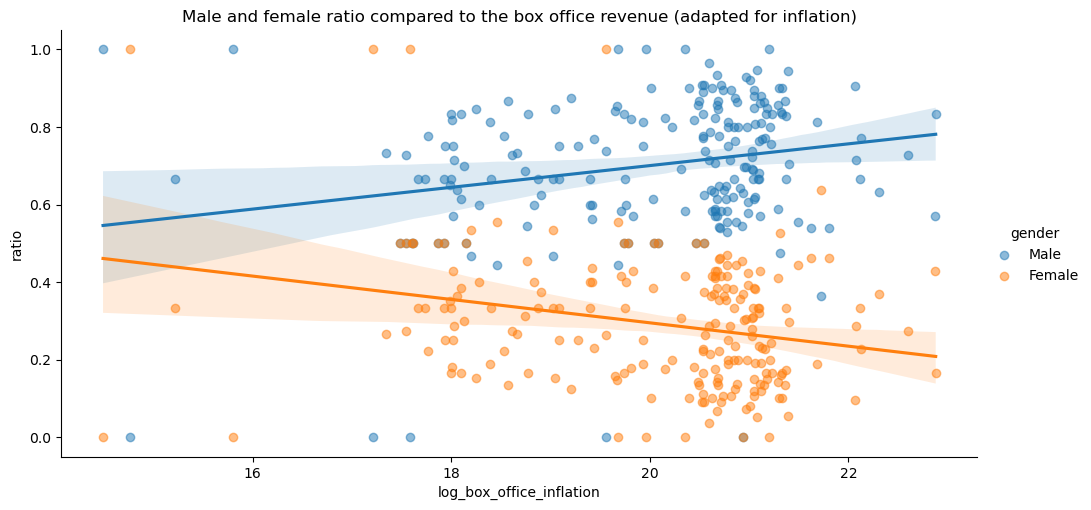

In [182]:
# Male / Female ratio regression
plot_df = top_movies[['log_box_office_inflation', 'm_ratio', 'f_ratio']] \
    .melt(id_vars='log_box_office_inflation', value_vars=['m_ratio', 'f_ratio']) \
    .rename(columns={'variable': 'gender', 'value': 'ratio'})

plot_df['gender'] = plot_df['gender'].apply(lambda x: 'Male' if x == 'm_ratio' else 'Female')

sns.lmplot(data=plot_df, x='log_box_office_inflation', y='ratio', hue='gender',
    # alpha=0.7
    height=5, aspect=2, scatter_kws={'alpha':0.5}
)

plt.title('Male and female ratio compared to the box office revenue (adapted for inflation)')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(PLOT_FOLDER + 'male_female_vs_box_office_regression.png', bbox_inches='tight')
plt.show()

# Does ethnical diversity and gender diversity correlate with the box office revenue?

In [ ]:
# TODO

# Statistical analysis
Pair matching
TODO add a small explanation text

In [145]:
#pair movies with similar budget values
# copy the movies dataframe before pair matching
movies_pm = movies.copy()

#merged_movies_budget['dupeIndex'] = merged_movies_budget.groupby(['occupation', 'gender', 'birthyear']).cumcount()

#add the earnings to the dataframe
movies_pm['earnings'] = movies_pm['box_office_revenue'] - movies_pm['budget']

#sort the dataframe by earnings
movies_pm = movies_pm.sort_values(by=['earnings'], ascending=False)

#get the year of the release date and merge the two dataframes on the year

matched_movies = movies_pm.merge(movies_pm, on=movies_pm['release_date'].dt.year, how='inner')
#matched_merged_movies_budget = merged_movies_budget.merge(merged_movies_budget, on= merged_movies_budget['budget'], how='inner')


#drop entries where the movie is the same
matched_movies = matched_movies[matched_movies['freebase_movie_id_x'] != matched_movies['freebase_movie_id_y']]


#drop entries where the budget is different by more than 50%
matched_movies = matched_movies[abs(matched_movies['budget_x'] - matched_movies['budget_y']) < 0.50 * matched_movies['budget_x']]

#drop entries where earnings_x is less than earnings_y
matched_movies = matched_movies[matched_movies['earnings_x'] > matched_movies['earnings_y']]



#add the earnings columns, earnings = box office revenue - budget
# matched_merged_movies_budget['earnings_x']=matched_merged_movies_budget['box_office_revenue_x']-matched_merged_movies_budget['budget_x']
# matched_merged_movies_budget['earnings_y']=matched_merged_movies_budget['box_office_revenue_y']-matched_merged_movies_budget['budget_y']
matched_movies.shape[0]

56876

In [146]:
#compare the similarity of the genres_x and genres_y
matched_movies['genre_similarity'] = matched_movies.apply(lambda x: SequenceMatcher(None, x['genres_x'], x['genres_y']).ratio(), axis=1)
matched_movies

#drop entries where the genre similarity is less than 0.4
matched_movies = matched_movies[matched_movies['genre_similarity'] > 0.4]
matched_movies.shape[0]

5360

In [147]:
#t test for f_ratio_x and f_ratio_y
ttest_ind(matched_movies['f_ratio_x'], matched_movies['f_ratio_y'])

Ttest_indResult(statistic=2.23211047196541, pvalue=0.02562824521044749)

In [148]:
(matched_movies['f_ratio_x']-matched_movies['f_ratio_y']).mean()

0.006786896642003537

In [149]:
#making sure the earnings_x is always greater than earnings_y
((matched_movies['earnings_x']-matched_movies['earnings_y'])>0).value_counts()

True    5360
dtype: int64

In [150]:
def my_bootstrap(f, df, n_iter= 100, low=0.025, high=0.975):
    """
        Compute the mean difference between the number of words in the winner and the loser headlines
        using bootstrap resampling.
    """
    results = np.zeros(n_iter)

    for i in range(n_iter):
        # sample both winners and losers headlines
        sample = df.sample(n=len(df), replace=True)

        # compute the ratio
        results[i] = f(sample)

    # compute global statistics
    mean = results.mean()
    q_low = np.quantile(results, low)
    q_high = np.quantile(results, high)

    return mean, q_low, q_high

n_iter = 1000

# dict to store mean, CI values and plot them
def print_usage(df, text, bootstrap_values, name="", low=0.025, high=0.975):
    mean, q_low, q_high = bootstrap_values
    ci = high - low
    print("{:66}{}: mean = {:+5.3f}, {:.1%} C.I.: [{:+5.5f}, {:+5.5f}]".format(text, name, mean, ci, q_low, q_high))

def print_usage_diff(df, name="", low=0.025, high=0.975):
    res = {}
    # Ratio
    #print_usage(df, "Mean ratio num words winner/loser headline", my_bootstrap(lambda df: (df['numwords1'] / df['numwords2']).mean(), df, n_iter, low, high))

    # Female words
    mean_pos, q_low_pos, q_high_pos = my_bootstrap(lambda df: (df['f_ratio_x']-df['f_ratio_y']).mean(), df, n_iter, low, high)
    res['f_ratio_y'] = (mean_pos, q_low_pos, q_high_pos)
    print_usage(df, "Mean diff female ratio word usage winner/loser headline", (mean_pos, q_low_pos, q_high_pos))

    #Male ratio
    mean_pos, q_low_pos, q_high_pos = my_bootstrap(lambda df: (df['m_ratio_x']-df['m_ratio_y']).mean(), df, n_iter, low, high)
    res['m_ratio_y'] = (mean_pos, q_low_pos, q_high_pos)
    print_usage(df, "Mean diff male ratio word usage winner/loser headline", (mean_pos, q_low_pos, q_high_pos))

    #Nan ratio
    mean_pos, q_low_pos, q_high_pos = my_bootstrap(lambda df: (df['nan_ratio_x']-df['nan_ratio_y']).mean(), df, n_iter, low, high)
    res['nan_ratio_y'] = (mean_pos, q_low_pos, q_high_pos)
    print_usage(df, "Mean diff nan ratio word usage winner/loser headline", (mean_pos, q_low_pos, q_high_pos))

    return res

def plot_errorbars(res, title, xlabel):
    # Plot means and CI for differences
    terms = np.array([x for x in res.keys()])
    means = np.array([x[0] for x in res.values()])
    ci_low = np.array([x[1] for x in res.values()])
    ci_high = np.array([x[2] for x in res.values()])

    plt.figure(figsize=(5, 4))
    plt.errorbar(means, np.array(range(len(means))), xerr=(means-ci_low, ci_high-means), linewidth = 1,
                linestyle = 'none',marker = 'o',markersize= 3,
                markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

    plt.vlines(0,0, len(means), linestyle = '--')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.yticks(range(len(terms)),terms)
    plt.show()

Mean diff female ratio word usage winner/loser headline           : mean = +0.007, 95.0% C.I.: [+0.00149, +0.01153]
Mean diff male ratio word usage winner/loser headline             : mean = -0.007, 95.0% C.I.: [-0.01233, -0.00197]
Mean diff nan ratio word usage winner/loser headline              : mean = -0.004, 95.0% C.I.: [-0.00735, -0.00165]


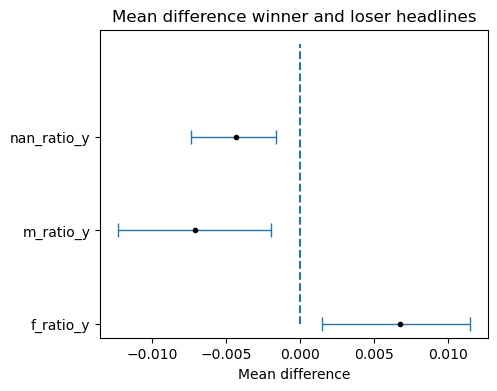

In [151]:
res = print_usage_diff(matched_movies)
plot_errorbars(res, "Mean difference winner and loser headlines", "Mean difference")

Mean diff female ratio word usage winner/loser headline           : mean = -0.150, 95.0% C.I.: [-0.27751, -0.03519]
Mean diff male ratio word usage winner/loser headline             : mean = +0.153, 95.0% C.I.: [+0.03689, +0.27454]
Mean diff nan ratio word usage winner/loser headline              : mean = -0.005, 95.0% C.I.: [-0.03230, +0.02168]


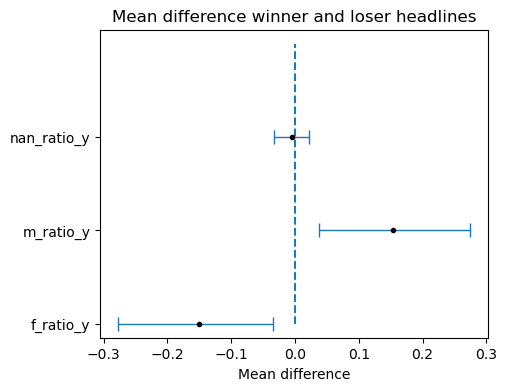

In [152]:
matched_merged_movies_budget_19 = matched_movies[matched_movies['release_date_x'].dt.year < 1950] 
res = print_usage_diff(matched_merged_movies_budget_19)
plot_errorbars(res, "Mean difference winner and loser headlines", "Mean difference")

Mean diff female ratio word usage winner/loser headline           : mean = +0.005, 95.0% C.I.: [-0.00160, +0.01090]
Mean diff male ratio word usage winner/loser headline             : mean = -0.004, 95.0% C.I.: [-0.00958, +0.00120]
Mean diff nan ratio word usage winner/loser headline              : mean = -0.006, 95.0% C.I.: [-0.00901, -0.00258]


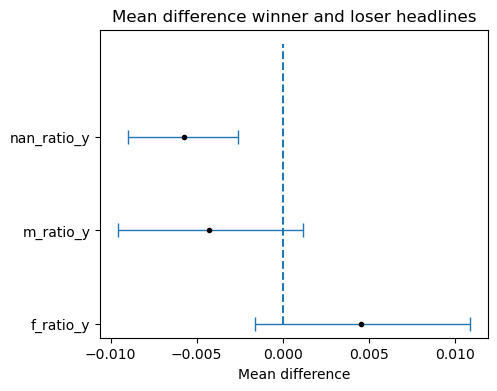

In [153]:
# only keep movies between 1950 and 2010
matched_merged_movies_budget_19_20 = matched_movies[matched_movies['release_date_x'].dt.year < 2010]
matched_merged_movies_budget_19_20 = matched_merged_movies_budget_19_20[matched_merged_movies_budget_19_20['release_date_x'].dt.year > 1949]
res = print_usage_diff(matched_merged_movies_budget_19_20)
plot_errorbars(res, "Mean difference winner and loser headlines", "Mean difference")

Mean diff female ratio word usage winner/loser headline           : mean = +0.017, 95.0% C.I.: [+0.00584, +0.02784]
Mean diff male ratio word usage winner/loser headline             : mean = -0.020, 95.0% C.I.: [-0.03079, -0.00693]
Mean diff nan ratio word usage winner/loser headline              : mean = +0.001, 95.0% C.I.: [-0.00558, +0.00664]


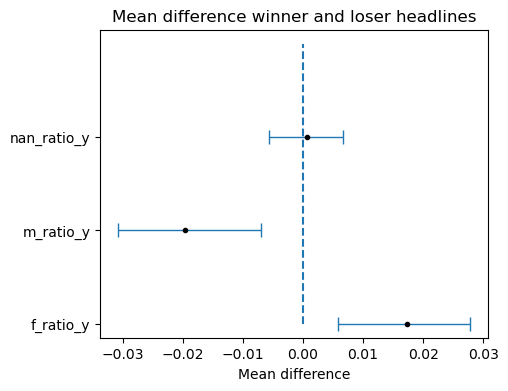

In [154]:
matched_merged_movies_budget_20 = matched_movies[matched_movies['release_date_x'].dt.year > 2009] 
res = print_usage_diff(matched_merged_movies_budget_20)
plot_errorbars(res, "Mean difference winner and loser headlines", "Mean difference")

C:\Users\colin_joci9zc\AppData\Local\Temp\ipykernel_25212\2275547682.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



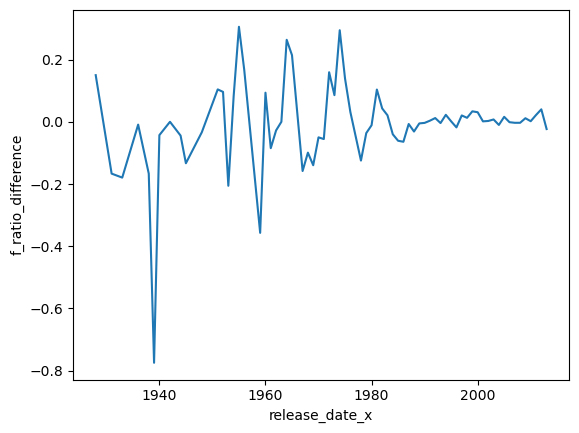

In [155]:
average_per_year = matched_movies.groupby(matched_movies['release_date_x'].dt.year).mean()
average_per_year['f_ratio_difference'] = average_per_year['f_ratio_x']-average_per_year['f_ratio_y']
sns.lineplot(data=average_per_year, x='release_date_x', y='f_ratio_difference')
plt.show()